In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import mstats
import pandas as pd

# Carregar dados de ciclovias
df_ciclovias = pd.read_excel(
    r'C:\Users\vimed\Downloads\dados_km_ciclovias.xlsx',
    engine='openpyxl'
)

# Carregar base principal
df = pd.read_excel(
    r'C:\Users\vimed\Downloads\Dados_Mestrado_07_05_2025 (1).NeW_Teste_@_Ajustado_Ajuste.xlsx',
    sheet_name='Banco_Geral_Oficial',
    engine='openpyxl'
)

# Limpar nomes de colunas e valores
df.columns = df.columns.str.replace('\t', '', regex=False).str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


# Filtrar colunas que quero
colunas_desejadas = [
    'id', 'altura', 'imc', 'idade', 'peso', 'datanasc', 'classificacao_origem',
    'fatores_atividade_fisica', 'Minutos Atividade Física Global_2015',
    'Categorias', 'sexo'
]
df = df[colunas_desejadas]

# Exibir DataFrame limpo




C:\Users\vimed\AppData\Local\Temp\ipykernel_36660\174058807.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [3]:
# Carregar dados adicionais (Onda 2 e 3)
df4 = pd.read_excel(
    r'C:\Users\vimed\Downloads\Novas_Ondas\Onda_2_e_3.xlsx',
    engine='openpyxl'
)

df_simulacao = pd.read_csv(
    r'C:\Users\vimed\Downloads\Peso_Simulado_5 anos.csv'
)

df_ml = df.merge(df4,right_on='id_original', left_on='id', how='inner')

df_ml = df_ml.merge(df_ciclovias,right_on='id', left_on='id', how='inner')
df_ml = df_simulacao.merge(df_ml, right_on='id', left_on='id', how='inner')


In [4]:

def limpeza(df_ml):
    # tirar certas colunas
    cols_to_drop = ['id_original', 'altura_2', 'id_original_3', 'altura_3', 'media_peso']
    df_ml = df_ml.drop(columns=cols_to_drop)
    
    # renomeando colunas
    df_ml = df_ml.rename(columns={
        'peso_final': 'Peso_final_simulado_2020',
        'imc_tratado_out_3': 'IMC_2024',
        'peso_3': 'peso_2024',
        'idade_3': 'idade_2024',
        'idade_2': 'idade_2020',
        'imc_tratado_out_2': 'imc_2020',
        'peso_2': 'peso_2020',
        'peso': 'peso_2015'
    })
    
    return df_ml

df_ml_limpo = limpeza(df_ml.copy())
df_ml_limpo.head()

df_ml = df_ml_limpo


In [5]:
df = df_ml

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

def limpar_e_converter(df):
   
    cols_numericas = ['peso_2015', 'altura', 'idade', 'Peso_final_simulado_2020', 
                     'Minutos Atividade Física Global_2015']
    
    for col in cols_numericas:
        
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), 
                               errors='coerce')
    df[cols_numericas] = df[cols_numericas].fillna(df[cols_numericas].median())   
    cols_categoricas = ['sexo', 'Categorias', 'fatores_atividade_fisica']
    df[cols_categoricas] = df[cols_categoricas].fillna('----')
    
    return df

In [7]:

# Calculo sobre o erro em relação ao real e ao simulado
def calcular_erro(df):
    df['erro'] = df['peso_2020'] - df['Peso_final_simulado_2020']
    return df


# Preparação para ML para 2024

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# 1. Copia o dataframe original
dados = df.copy()

# 2. Converter sexo para número
dados['sexo'] = dados['sexo'].map({'M': 1, 'F': 0})

# 3. Calcular idade a partir da data de nascimento 
dados['datanasc'] = pd.to_datetime(dados['datanasc'], dayfirst=True, errors='coerce')
dados['idade'] = (pd.to_datetime('2020-12-31') - dados['datanasc']).dt.days / 365.25

# 4.Dados de Peso 
dados = dados.dropna(subset=['peso_2015', 'altura', 'peso_2020', 'imc'])


In [9]:
# Variáveis que usaremos para prever
features = ['peso_2015', 'altura', 'imc', 'idade', 'sexo', 'fatores_atividade_fisica']

# Variável que quero prever
alvo = 'peso_2024'

# 
features_disponiveis = [f for f in features if f in dados.columns]

# Separar ID dos dados de features
X = dados[features_disponiveis].copy()  # entrada
y = dados[alvo]                       # O que quero prever
ids = dados['id']                       # IDs das pessoas

# conversao para float e tratamento caso tenha virgulas separando! 
for col in X.columns:
    if X[col].dtype == object:
        X.loc[:, col] = X[col].astype(str).str.replace(',', '.').astype(float)

# Criei um dataframe com as features,alvo e Id
df_total = pd.concat([X, y.rename('alvo'), ids.rename('id')], axis=1)
df_total = df_total.dropna()

X = df_total[X.columns]
y = df_total['alvo']
ids = df_total['id']

# Separação dos dados em conjunto de treino(70%) e o teste(30%) de forma aleatoria
# inclusão dos parametros de aleatoriedade
df_treino, df_teste = train_test_split(df_total, test_size=0.3, random_state=42)

X_treino = df_treino[X.columns]
y_treino = df_treino['alvo']
ids_treino = df_treino['id']

X_teste = df_teste[X.columns] 
y_teste = df_teste['alvo'] 
ids_teste = df_teste['id']

print(X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape, ids_treino.shape, ids_teste.shape)


(524, 6) (225, 6) (524,) (225,) (524,) (225,)


# Treinamento

In [10]:
# Importacao de bibilioteca de Floresta Aleatoria
# Importação de Metricas
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Criação do Modelo de Floresta Aleatória
# n_estimators = número de arvores
# max_depth= profundidade maxima de cada arvore
#estados aleatorio para garantir a reprodutibilidade
modelo = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=100)
#Execução do modelo
modelo.fit(X_treino, y_treino)
print(" Modelo treinado")
# previsão no Conjunto Teste
y_previsto = modelo.predict(X_teste)
# calculo da métrica de avaliação do erro medio quadratico(entre o real e o previsto)
erro_medio_quadratico = mean_squared_error(y_teste, y_previsto)
# R2 scores: proporção de variação do modelo
r2 = r2_score(y_teste, y_previsto)
print(erro_medio_quadratico, r2)
# criação do dataframe
resultados = X_teste.copy()
resultados['id'] = ids_teste.values
resultados['peso_real'] = y_teste.values
resultados['peso_previsto'] = y_previsto




 Modelo treinado
86.52302743046464 0.6907999883062785


In [11]:
# previsao com o modelo 
previsoes = modelo.predict(X_teste)
#criacao de dataframe
df_previsoes = pd.DataFrame({
    'peso_real': y_teste.values,  
    'peso_previsto': previsoes
})
#calculo do erro absoluto
df_previsoes['erro_absoluto'] = abs(df_previsoes['peso_previsto'] - df_previsoes['peso_real'])

# Cálculo do erro médio
erro_medio = df_previsoes['erro_absoluto'].mean()

#  erros medio, minimo e maximo e medio
print(f"Erro médio: {erro_medio:.2f} kg")
print(f"Erro mínimo: {df_previsoes['erro_absoluto'].min():.2f} kg")
print(f"Erro máximo: {df_previsoes['erro_absoluto'].max():.2f} kg")
# os top maiores errs
print("\n5 maiores erros:")
print(df_previsoes.nlargest(5, 'erro_absoluto')[['peso_real', 'erro_absoluto']])
# os tops menores erros
print("\n5 menores erros:")
print(df_previsoes.nsmallest(5, 'erro_absoluto')[['peso_real', 'erro_absoluto']])


Erro médio: 6.71 kg
Erro mínimo: 0.00 kg
Erro máximo: 43.60 kg

5 maiores erros:
     peso_real  erro_absoluto
196      130.0      43.600000
107       73.0      36.634000
224      120.0      33.790000
111       92.0      28.277603
151       90.0      23.635607

5 menores erros:
     peso_real  erro_absoluto
171       70.0       0.000095
130       63.0       0.028008
186       63.0       0.070803
71        66.0       0.085000
44        74.0       0.262500


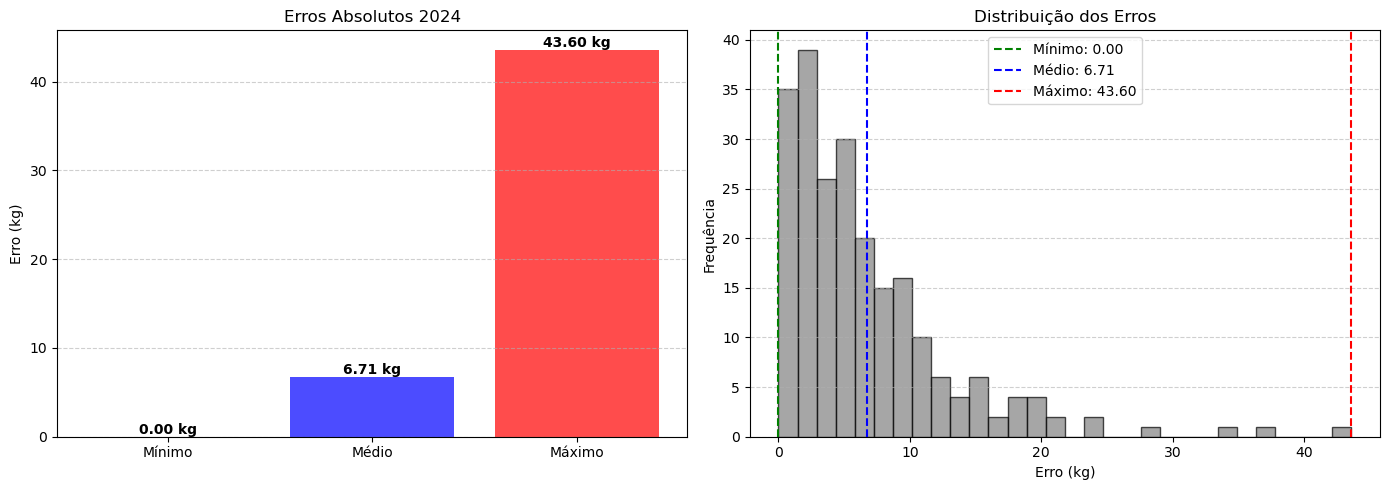

In [12]:
import matplotlib.pyplot as plt

erros = df_previsoes['erro_absoluto']
erro_min, erro_medio, erro_max = erros.min(), erros.mean(), erros.max()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(['Mínimo', 'Médio', 'Máximo'], [erro_min, erro_medio, erro_max],
            color=['green', 'blue', 'red'], alpha=0.7)
for i, val in enumerate([erro_min, erro_medio, erro_max]):
    axes[0].text(i, val, f"{val:.2f} kg", ha='center', va='bottom', fontweight='bold')
axes[0].set_title("Erros Absolutos 2024")
axes[0].set_ylabel("Erro (kg)")
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Histograma
axes[1].hist(erros, bins=30, alpha=0.7, color='gray', edgecolor='black')
for val, color, label in zip([erro_min, erro_medio, erro_max], ['green', 'blue', 'red'],
                             ['Mínimo', 'Médio', 'Máximo']):
    axes[1].axvline(val, color=color, linestyle='--', label=f"{label}: {val:.2f}")
axes[1].set_title("Distribuição dos Erros")
axes[1].set_xlabel("Erro (kg)")
axes[1].set_ylabel("Frequência")
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# Machine Learning 2020

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# 1. 
dados = df.copy()

# 2. Converter sexo para número
dados['sexo'] = dados['sexo'].map({'M': 1, 'F': 0})

# 3. Calcular idade a partir da data de nascimento 
dados['datanasc'] = pd.to_datetime(dados['datanasc'], dayfirst=True, errors='coerce')
dados['idade'] = (pd.to_datetime('2020-12-31') - dados['datanasc']).dt.days / 365.25

# 4.Dados de Peso 
dados = dados.dropna(subset=['peso_2015', 'altura', 'peso_2020', 'imc'])


In [14]:
# Variáveis que usaremos para prever
features = ['peso_2015', 'altura', 'imc', 'idade', 'sexo', 'fatores_atividade_fisica']

# Variável que quero prever
alvo = 'peso_2020'

# 
features_disponiveis = [f for f in features if f in dados.columns]

# Separar ID dos dados de features
X = dados[features_disponiveis].copy()  # entrada
y = dados[alvo]                       # O que quero prever
ids = dados['id']                       # IDs das pessoas

# conversao para float e tratamento caso tenha virgulas separando! 
for col in X.columns:
    if X[col].dtype == object:
        X.loc[:, col] = X[col].astype(str).str.replace(',', '.').astype(float)

# Criei um dataframe com as features,alvo e Id
df_total = pd.concat([X, y.rename('alvo'), ids.rename('id')], axis=1)
df_total = df_total.dropna()

X = df_total[X.columns]
y = df_total['alvo']
ids = df_total['id']

# Separação dos dados em conjunto de treino(70%) e o teste(30%) de forma aleatoria
# inclusão dos parametros de aleatoriedade
df_treino, df_teste = train_test_split(df_total, test_size=0.3, random_state=42)

X_treino = df_treino[X.columns]
y_treino = df_treino['alvo']
ids_treino = df_treino['id']

X_teste = df_teste[X.columns] 
y_teste = df_teste['alvo'] 
ids_teste = df_teste['id']

print(X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape, ids_treino.shape, ids_teste.shape)


(527, 6) (227, 6) (527,) (227,) (527,) (227,)


# Treinamento

In [15]:
# Importacao de bibilioteca de Floresta Aleatoria
# Importação de Metricas
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Criação do Modelo de Floresta Aleatória
# n_estimators = número de arvores
# max_depth= profundidade maxima de cada arvore
#estados aleatorio para garantir a reprodutibilidade
modelo = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=100)
#Execução do modelo
modelo.fit(X_treino, y_treino)
print(" Modelo treinado")
# previsão no Conjunto Teste
y_previsto = modelo.predict(X_teste)
# calculo da métrica de avaliação do erro medio quadratico(entre o real e o previsto)
erro_medio_quadratico = mean_squared_error(y_teste, y_previsto)
# R2 scores: proporção de variação do modelo
r2 = r2_score(y_teste, y_previsto)
print(erro_medio_quadratico, r2)
# criação do dataframe
resultados = X_teste.copy()
resultados['id'] = ids_teste.values
resultados['peso_real'] = y_teste.values
resultados['peso_previsto'] = y_previsto




 Modelo treinado
67.7038091597861 0.7624949792850735


In [16]:
# previsao com o modelo 
previsoes = modelo.predict(X_teste)
#criacao de dataframe
df_previsoes = pd.DataFrame({
    'peso_real': y_teste.values,  
    'peso_previsto': previsoes
})
#calculo do erro absoluto
df_previsoes['erro_absoluto'] = abs(df_previsoes['peso_previsto'] - df_previsoes['peso_real'])

# Cálculo do erro médio
erro_medio = df_previsoes['erro_absoluto'].mean()

#  erros medio, minimo e maximo e medio
print(f"Erro médio: {erro_medio:.2f} kg")
print(f"Erro mínimo: {df_previsoes['erro_absoluto'].min():.2f} kg")
print(f"Erro máximo: {df_previsoes['erro_absoluto'].max():.2f} kg")
# os top maiores errs
print("\n5 maiores erros:")
print(df_previsoes.nlargest(5, 'erro_absoluto')[['peso_real', 'erro_absoluto']])
# os tops menores erros
print("\n5 menores erros:")
print(df_previsoes.nsmallest(5, 'erro_absoluto')[['peso_real', 'erro_absoluto']])


Erro médio: 6.03 kg
Erro mínimo: 0.02 kg
Erro máximo: 38.77 kg

5 maiores erros:
     peso_real  erro_absoluto
40        58.0      38.770833
36        84.0      26.962500
27        60.0      24.895000
104       68.0      20.305000
56        50.0      20.068187

5 menores erros:
     peso_real  erro_absoluto
32        92.0       0.022444
189       55.0       0.030900
131       53.0       0.046654
204       54.0       0.133337
53        70.0       0.174727


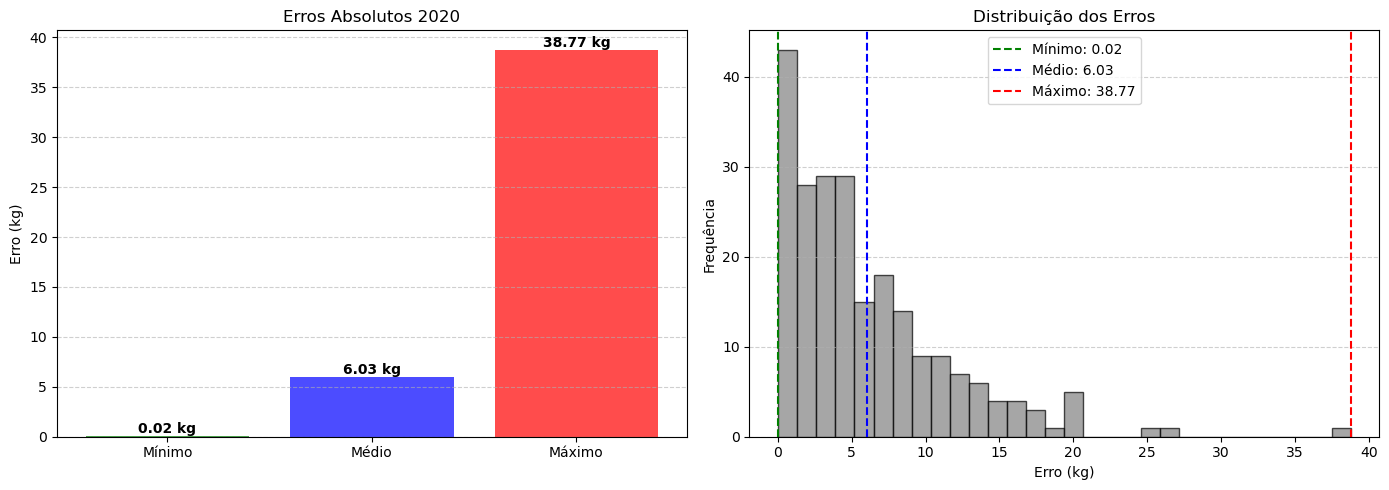

In [17]:
import matplotlib.pyplot as plt

erros = df_previsoes['erro_absoluto']
erro_min, erro_medio, erro_max = erros.min(), erros.mean(), erros.max()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(['Mínimo', 'Médio', 'Máximo'], [erro_min, erro_medio, erro_max],
            color=['green', 'blue', 'red'], alpha=0.7)
for i, val in enumerate([erro_min, erro_medio, erro_max]):
    axes[0].text(i, val, f"{val:.2f} kg", ha='center', va='bottom', fontweight='bold')
axes[0].set_title("Erros Absolutos 2020")
axes[0].set_ylabel("Erro (kg)")
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Histograma
axes[1].hist(erros, bins=30, alpha=0.7, color='gray', edgecolor='black')
for val, color, label in zip([erro_min, erro_medio, erro_max], ['green', 'blue', 'red'],
                             ['Mínimo', 'Médio', 'Máximo']):
    axes[1].axvline(val, color=color, linestyle='--', label=f"{label}: {val:.2f}")
axes[1].set_title("Distribuição dos Erros")
axes[1].set_xlabel("Erro (kg)")
axes[1].set_ylabel("Frequência")
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


# Comparacao

In [18]:
import pandas as pd
df_arvore = pd.read_csv(r'C:\Users\vimed\Downloads\Arvore aleatoria.csv')

df_simulacao = pd.read_csv(r'C:\Users\vimed\Downloads\Simulação Normal.csv')
df_comparacao = df_simulacao.merge(df_arvore,right_on='id', left_on='id', how='inner')
df_comparacao = df_comparacao.drop_duplicates()


In [19]:
import pandas as pd
import numpy as np



# calculo do erro medio da previsao probabilistica
erro_medio_previsao = np.mean(np.abs(df_comparacao['peso_ano_2020'] - df_comparacao['peso_real_2020']))
# calculo do erro medio da previsao floresta aleatoria

erro_medio_floresta = np.mean(np.abs(df_comparacao['peso_previso_floresta_aleatoria'] - df_comparacao['peso_real_2020']))
print(f"Erro médio - Previsão simples: {erro_medio_previsao:.2f}")
print(f"Erro médio - Floresta Aleatória: {erro_medio_floresta:.2f}")

# Calculo de proximidade porcentual  entre os valores reais e os previstos
df_comparacao['proximidade_previsao'] = 100 * (1 - np.abs(df_comparacao['peso_ano_2020'] - df_comparacao['peso_real_2020']) / df_comparacao['peso_real_2020'])
df_comparacao['proximidade_floresta'] = 100 * (1 - np.abs(df_comparacao['peso_previso_floresta_aleatoria'] - df_comparacao['peso_real_2020']) / df_comparacao['peso_real_2020'])

# 
df_percentual = df_comparacao[['id', 'proximidade_previsao', 'proximidade_floresta']]



Erro médio - Previsão simples: 8.26
Erro médio - Floresta Aleatória: 6.40


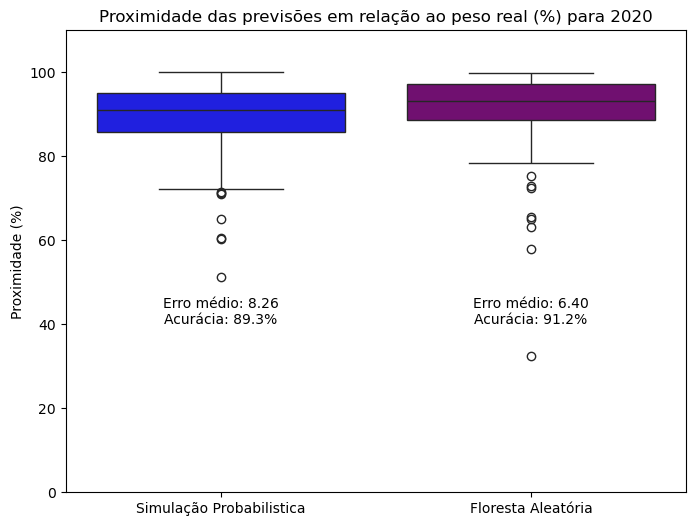

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# estrutura das figuras
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df_percentual[['proximidade_previsao','proximidade_floresta']], 
                 palette=["blue","purple"])

plt.title("Proximidade das previsões em relação ao peso real (%) para 2020")
plt.ylabel("Proximidade (%)")
plt.xticks([0,1], ["Simulação Probabilistica", "Floresta Aleatória"])

# Calcula os erros médios
erro_medio_previsao = np.mean(np.abs(df_comparacao['peso_ano_2020'] - df_comparacao['peso_real_2020']))
erro_medio_floresta = np.mean(np.abs(df_comparacao['peso_previso_floresta_aleatoria'] - df_comparacao['peso_real_2020']))

# Calcula a acurácia média (proximidade)
acuracia_previsao = df_percentual['proximidade_previsao'].mean()
acuracia_floresta = df_percentual['proximidade_floresta'].mean()

ax.text(0, 40, f"Erro médio: {erro_medio_previsao:.2f}\nAcurácia: {acuracia_previsao:.1f}%", 
        ha='center', fontsize=10)
ax.text(1, 40, f"Erro médio: {erro_medio_floresta:.2f}\nAcurácia: {acuracia_floresta:.1f}%", 
        ha='center', fontsize=10)

plt.ylim(0, 110)
plt.show()


# Comparação  em relação ao ML 2024

In [21]:
import pandas as pd
df_arvore = pd.read_csv(r'C:/Users/vimed\Downloads/aprendizagem_maquina2024.csv')

df_simulacao = pd.read_csv(r'C:/Users/vimed/Downloads/Dados_simulacao_2024.csv')
df_comparacao = df_simulacao.merge(df_arvore,right_on='id', left_on='id', how='inner')
df_comparacao = df_comparacao.drop_duplicates()


In [22]:
df_comparacao.columns

Index(['id', 'Categorias', 'altura', 'Peso_2015', 'Peso_2016', 'Peso_2017',
       'Peso_2018', 'Peso_2019', 'Peso_2020', 'Peso_2021', 'Peso_2022',
       'Peso_2023', 'Peso_2024', 'IMC_2015', 'IMC_2016', 'IMC_2017',
       'IMC_2018', 'IMC_2019', 'IMC_2020', 'IMC_2021', 'IMC_2022', 'IMC_2023',
       'IMC_2024', 'peso_real', 'peso_previsto', 'erro_absoluto'],
      dtype='object')

In [23]:
import pandas as pd
import numpy as np

# calculo do erro medio da previsao probabilistica
erro_medio_previsao = np.mean(np.abs(df_comparacao['Peso_2024'] - df_comparacao['peso_real']))
# calculo do erro medio da previsao floresta aleatoria

erro_medio_floresta = np.mean(np.abs(df_comparacao['peso_previsto'] - df_comparacao['peso_real']))

print(f"Erro médio - Previsão simples: {erro_medio_previsao:.2f}")
print(f"Erro médio - Floresta Aleatória: {erro_medio_floresta:.2f}")

## Calculo de proximidade porcentual  entre os valores reais e os previstos

df_comparacao['proximidade_previsao'] = 100 * (1 - np.abs(df_comparacao['Peso_2024'] - df_comparacao['peso_real']) /  df_comparacao['peso_real'])
df_comparacao['proximidade_floresta'] = 100 * (1 - np.abs(df_comparacao['peso_previsto'] - df_comparacao['peso_real']) /df_comparacao['peso_real'])


df_percentual = df_comparacao[['id', 'proximidade_previsao', 'proximidade_floresta']]


Erro médio - Previsão simples: 13.00
Erro médio - Floresta Aleatória: 6.71


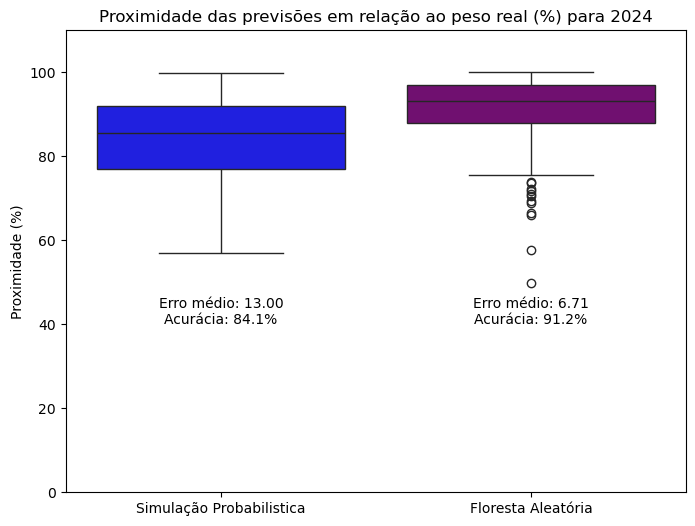

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Estrutura dos graficos
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df_percentual[['proximidade_previsao','proximidade_floresta']], 
                 palette=["blue","purple"])

plt.title("Proximidade das previsões em relação ao peso real (%) para 2024")
plt.ylabel("Proximidade (%)")
plt.xticks([0,1], ["Simulação Probabilistica", "Floresta Aleatória"])

# Calcula os erros médios
erro_medio_previsao = np.mean(np.abs(df_comparacao['Peso_2024'] - df_comparacao['peso_real']))
erro_medio_floresta = np.mean(np.abs(df_comparacao['peso_previsto'] - df_comparacao['peso_real']))

# Acurácia Media
acuracia_previsao = df_percentual['proximidade_previsao'].mean()
acuracia_floresta = df_percentual['proximidade_floresta'].mean()


ax.text(0, 40, f"Erro médio: {erro_medio_previsao:.2f}\nAcurácia: {acuracia_previsao:.1f}%", 
        ha='center', fontsize=10)
ax.text(1, 40, f"Erro médio: {erro_medio_floresta:.2f}\nAcurácia: {acuracia_floresta:.1f}%", 
        ha='center', fontsize=10)

plt.ylim(0, 110)  
plt.show()
